# Project Storm: Frequency & Severity Analysis + Distribution Fitting

This notebook focuses on analyzing the historical frequency and severity of weather events based on the cleaned and mapped data. We will:

1.  **Analyze Historical Frequency:** Aggregate the `county_events.csv` data to understand event counts per county/region over time.
2.  **Fit Frequency Distributions:** Fit statistical distributions (Poisson, Negative Binomial) to these historical counts.
3.  **Analyze Historical Severity:** Examine the distributions of severity metrics (e.g., wind speed, acres burned) from the original cleaned datasets.
4.  **Fit Severity Distributions:** Fit statistical distributions (Gamma, Lognormal, Weibull) to these severity metrics.

The outputs (fitted parameters, goodness-of-fit) will be logged and printed, ready for the next stage: scenario modeling and Monte Carlo simulation.

In [2]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import io
from collections import Counter

# --- Configuration ---
# Define regions based on states (adjust as needed from original prompt)
REGION_MAP = {
    'AL': 'Southeast', 'FL': 'Southeast', 'GA': 'Southeast', 'MS': 'Southeast', 'NC': 'Southeast', 'SC': 'Southeast', 'TN': 'Southeast',
    'AR': 'South', 'KY': 'South', 'LA': 'South', 'VA': 'South', 'WV': 'South',
    'AZ': 'West', 'CA': 'West', 'CO': 'West', 'NV': 'West', 'NM': 'West', 'UT': 'West', 'OK': 'West', 'TX': 'West'
    # Add other states if your county data includes them
}

# Paths to input files
COUNTY_EVENTS_PATH = "../output/final/county_events.csv"
COUNTIES_PATH = "../data/counties/2024_counties.txt" # Needed for state/region mapping
HURDAT_CLEAN_PATH = "../output/cleaned/noaa_hurdat_clean.csv"
WILDFIRES_CLEAN_PATH = "../output/cleaned/california_wildfires_clean.csv"
STORMEVENTS_CLEAN_PATH = "../output/cleaned/stormevents_2014_2024_cleaned.csv"

# Output directory for analysis results
ANALYSIS_OUTPUT_DIR = "../output/analysis"
os.makedirs(ANALYSIS_OUTPUT_DIR, exist_ok=True)

# --- Setup Logger ---
LOG_FILE = "../logs/fitting_log.log"
logger = logging.getLogger("FittingLogger")
logger.setLevel(logging.DEBUG) # Capture all levels

# Avoid adding multiple handlers
if not logger.handlers:
    # File handler
    fh = logging.FileHandler(LOG_FILE, mode='w') # Overwrite log each run
    fh.setLevel(logging.DEBUG)
    fh_formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
    fh.setFormatter(fh_formatter)
    logger.addHandler(fh)

    # Console handler
    sh = logging.StreamHandler()
    sh.setLevel(logging.INFO) # Show INFO level and above on console
    sh_formatter = logging.Formatter("[%(asctime)s] [%(levelname)s] %(name)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S")
    sh.setFormatter(sh_formatter)
    logger.addHandler(sh)

logger.info("--- Notebook Setup Complete ---")

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size

[2025-04-10 15:50:59] [INFO] FittingLogger - --- Notebook Setup Complete ---


In [3]:
# --- Load Data ---

logger.info("Loading input data...")
df_county_events = pd.DataFrame() # Initialize
df_counties = pd.DataFrame() # Initialize

# Load county events
try:
    df_county_events = pd.read_csv(COUNTY_EVENTS_PATH, low_memory=False)
    logger.info(f"Loaded {len(df_county_events)} rows from {COUNTY_EVENTS_PATH}")

    if 'county_geoid' in df_county_events.columns:
        logger.info("Converting 'county_geoid' in county_events to string dtype for merge.")
        df_county_events['county_geoid'] = df_county_events['county_geoid'].astype(str).str.strip() # Ensure string and strip spaces
        # Optional: Pad with zeros if necessary (e.g., if you expect '01001' but have '1001')
        # df_county_events['county_geoid'] = df_county_events['county_geoid'].str.zfill(5)
    else:
        logger.error("'county_geoid' column not found in county_events file. Cannot merge regions.")
        raise ValueError("'county_geoid' column missing in county_events file.") # Stop if key column missing

    if 'first_impact_dt' in df_county_events.columns:
        logger.info("Attempting to convert 'first_impact_dt' to datetime...")
        original_type = str(df_county_events['first_impact_dt'].dtype)
        df_county_events['first_impact_dt'] = pd.to_datetime(df_county_events['first_impact_dt'], errors='coerce')
        converted_type = str(df_county_events['first_impact_dt'].dtype)
        if pd.api.types.is_datetime64_any_dtype(df_county_events['first_impact_dt']):
            logger.info(f"Successfully converted 'first_impact_dt' from {original_type} to {converted_type}.")
            df_county_events['year'] = df_county_events['first_impact_dt'].dt.year
            nat_count = df_county_events['first_impact_dt'].isna().sum()
            if nat_count > 0: logger.warning(f"Coerced {nat_count} invalid date entries in 'first_impact_dt' to NaT.")
        else:
            logger.error(f"Failed to convert 'first_impact_dt' to datetime. Column type remains {converted_type}.")
            df_county_events['year'] = np.nan
    else:
        logger.error("'first_impact_dt' column not found.")
        df_county_events['year'] = np.nan

except FileNotFoundError:
    logger.error(f"County events file not found: {COUNTY_EVENTS_PATH}")
except Exception as e:
    logger.exception(f"An error occurred loading or processing {COUNTY_EVENTS_PATH}: {e}")

# Load county details for region mapping
try:
    df_counties = pd.read_csv(COUNTIES_PATH, delimiter='\t', dtype=str)
    df_counties.columns = df_counties.columns.str.strip()
    df_counties = df_counties[['GEOID', 'USPS']].rename(columns={'GEOID': 'county_geoid'})
    df_counties['county_geoid'] = df_counties['county_geoid'].astype(str).str.strip() # Ensure string and strip spaces
    # Optional: Pad if needed
    # df_counties['county_geoid'] = df_counties['county_geoid'].str.zfill(5)
    df_counties['region'] = df_counties['USPS'].map(REGION_MAP)
    logger.info(f"Loaded {len(df_counties)} county definitions from {COUNTIES_PATH}")

except FileNotFoundError:
    logger.error(f"Counties definition file not found: {COUNTIES_PATH}")
except Exception as e:
     logger.exception(f"An error occurred loading or processing {COUNTIES_PATH}: {e}")

# --- Perform the merge only if both dataframes are ready ---
if not df_county_events.empty and 'county_geoid' in df_county_events.columns and not df_counties.empty:
    logger.info("Merging county definitions (region) onto county events...")
    type1 = df_county_events['county_geoid'].dtype
    type2 = df_counties['county_geoid'].dtype
    logger.debug(f"Merge key 'county_geoid' dtypes: df_county_events ({type1}), df_counties ({type2})")
    if type1 != type2:
        logger.warning(f"Attempting merge with different key dtypes ({type1} vs {type2}). Forcing both to string.")
        try:
             df_county_events['county_geoid'] = df_county_events['county_geoid'].astype(str).str.strip()
             df_counties['county_geoid'] = df_counties['county_geoid'].astype(str).str.strip()
             logger.info("Re-ensured merge keys are string type.")
        except Exception as convert_e:
             logger.error(f"Failed to ensure consistent string dtype for merge keys: {convert_e}")

    # Perform the merge
    df_county_events_merged = pd.merge(df_county_events, df_counties[['county_geoid', 'USPS', 'region']], on='county_geoid', how='left')
    logger.info("Merge complete.")
    missing_regions = df_county_events_merged['region'].isnull().sum()
    if missing_regions > 0:
         logger.warning(f"{missing_regions} event records could not be mapped to a region (likely unmatched county_geoid).")

         # --- DEBUGGING UNMATCHED GEOIDS ---
         logger.info("--- Debugging unmatched county_geoid values ---")
         df_unmatched = df_county_events_merged[df_county_events_merged['region'].isnull()].copy()
         unique_unmatched_geoids = df_unmatched['county_geoid'].unique()
         logger.info(f"Found {len(unique_unmatched_geoids)} unique 'county_geoid' values in events data that did not match the counties definition file.")

         # Print a sample of unmatched GEOIDs
         sample_size = min(20, len(unique_unmatched_geoids))
         logger.info(f"Sample of unmatched county_geoid values:\n{unique_unmatched_geoids[:sample_size]}")
         print(f"\n--- Sample of {sample_size} Unmatched county_geoid values ---")
         print(unique_unmatched_geoids[:sample_size])

         # Check format: Are they 5 digits? Are they numeric-like?
         geoid_formats = df_unmatched['county_geoid'].apply(lambda x: f"len={len(str(x))}, isdigit={'Y' if str(x).isdigit() else 'N'}").value_counts()
         logger.info(f"Formats of unmatched county_geoid values:\n{geoid_formats.to_string()}")
         print("\n--- Formats of Unmatched county_geoid values ---")
         print(geoid_formats)

         # Check event types associated with unmatched GEOIDs
         event_type_dist = df_unmatched['event_type'].value_counts(normalize=True)
         logger.info(f"Distribution of event_type for unmatched records:\n{event_type_dist.to_string()}")
         print("\n--- Distribution of Event Types for Unmatched Records ---")
         print(event_type_dist)

         # Compare unmatched against known valid GEOIDs
         valid_geoids = set(df_counties['county_geoid'].unique())
         unmatched_not_in_valid = [g for g in unique_unmatched_geoids if g not in valid_geoids]
         logger.info(f"{len(unmatched_not_in_valid)} unique unmatched GEOIDs are truly absent from the counties definition file.")
         if len(unmatched_not_in_valid) > 0:
              sample_absent = min(20, len(unmatched_not_in_valid))
              logger.info(f"Sample of GEOIDs absent from counties file:\n{unmatched_not_in_valid[:sample_absent]}")
              print(f"\n--- Sample of {sample_absent} GEOIDs completely absent from counties file ---")
              print(unmatched_not_in_valid[:sample_absent])
         # --- END DEBUGGING ---

    # Assign the merged dataframe back (important!)
    df_county_events = df_county_events_merged

elif not df_county_events.empty:
    # Add columns if merge skipped because df_counties was empty
    logger.warning("County definitions empty or missing. Adding empty 'USPS' and 'region' columns.")
    df_county_events['USPS'] = None
    df_county_events['region'] = None


# --- Load original cleaned data for severity analysis ---
# (Keep the robust loading try-except blocks from previous answer)
try:
    df_hurdat = pd.read_csv(HURDAT_CLEAN_PATH, parse_dates=['datetime'])
    logger.info(f"Loaded {len(df_hurdat)} HURDAT rows for severity analysis.")
except FileNotFoundError: logger.error(f"HURDAT cleaned file not found: {HURDAT_CLEAN_PATH}"); df_hurdat = pd.DataFrame()
except Exception as e: logger.exception(f"Error loading {HURDAT_CLEAN_PATH}: {e}"); df_hurdat = pd.DataFrame()

try:
    df_wildfires = pd.read_csv(WILDFIRES_CLEAN_PATH, parse_dates=['incident_date_created'])
    logger.info(f"Loaded {len(df_wildfires)} Wildfire rows for severity analysis.")
except FileNotFoundError: logger.error(f"Wildfires cleaned file not found: {WILDFIRES_CLEAN_PATH}"); df_wildfires = pd.DataFrame()
except Exception as e: logger.exception(f"Error loading {WILDFIRES_CLEAN_PATH}: {e}"); df_wildfires = pd.DataFrame()

try:
    df_stormevents = pd.read_csv(STORMEVENTS_CLEAN_PATH, low_memory=False)
    if 'BEGIN_DATE_TIME' in df_stormevents.columns:
        df_stormevents['BEGIN_DATE_TIME'] = pd.to_datetime(df_stormevents['BEGIN_DATE_TIME'], errors='coerce')
        nat_count_storm = df_stormevents['BEGIN_DATE_TIME'].isna().sum()
        if nat_count_storm > 0: logger.warning(f"Coerced {nat_count_storm} invalid date entries in StormEvents 'BEGIN_DATE_TIME' to NaT.")
    logger.info(f"Loaded {len(df_stormevents)} StormEvent rows for severity analysis.")
except FileNotFoundError: logger.error(f"StormEvents cleaned file not found: {STORMEVENTS_CLEAN_PATH}"); df_stormevents = pd.DataFrame()
except Exception as e: logger.exception(f"Error loading {STORMEVENTS_CLEAN_PATH}: {e}"); df_stormevents = pd.DataFrame()


logger.info("--- Data Loading Complete ---")

# Display heads to verify (only if DataFrames are not empty)
if not df_county_events.empty:
    print("\nCounty Events Head (after merge attempt):")
    display(df_county_events.head())
# ... (display heads for other dataframes) ...
if not df_hurdat.empty: print("\nHURDAT Head:"); display(df_hurdat.head())
if not df_wildfires.empty: print("\nWildfires Head:"); display(df_wildfires.head())
if not df_stormevents.empty: print("\nStormEvents Head:"); display(df_stormevents.head())

[2025-04-10 15:50:59] [INFO] FittingLogger - Loading input data...
[2025-04-10 15:50:59] [INFO] FittingLogger - Loaded 226538 rows from ../output/final/county_events.csv
[2025-04-10 15:50:59] [INFO] FittingLogger - Converting 'county_geoid' in county_events to string dtype for merge.
[2025-04-10 15:50:59] [INFO] FittingLogger - Attempting to convert 'first_impact_dt' to datetime...
[2025-04-10 15:51:00] [INFO] FittingLogger - Successfully converted 'first_impact_dt' from object to datetime64[ns].
[2025-04-10 15:51:00] [INFO] FittingLogger - Loaded 3222 county definitions from ../data/counties/2024_counties.txt
[2025-04-10 15:51:00] [INFO] FittingLogger - Merging county definitions (region) onto county events...
[2025-04-10 15:51:00] [INFO] FittingLogger - Merge complete.
[2025-04-10 15:51:00] [WARNING] FittingLogger - 119527 event records could not be mapped to a region (likely unmatched county_geoid).
[2025-04-10 15:51:00] [INFO] FittingLogger - --- Debugging unmatched county_geoid va


--- Sample of 20 Unmatched county_geoid values ---
['1097' '1003' '1025' '1099' '1129' '1035' '1053' '1013' '1131' '1091'
 '1047' '1041' '1109' '1011' '1085' '1101' '1087' '1037' '1001' '1051']

--- Formats of Unmatched county_geoid values ---
county_geoid
len=5, isdigit=Y    101993
len=4, isdigit=Y     17534
Name: count, dtype: int64

--- Distribution of Event Types for Unmatched Records ---
event_type
scs_wind     0.903587
hurricane    0.096321
wildfire     0.000092
Name: proportion, dtype: float64

--- Sample of 20 GEOIDs completely absent from counties file ---
['1097', '1003', '1025', '1099', '1129', '1035', '1053', '1013', '1131', '1091', '1047', '1041', '1109', '1011', '1085', '1101', '1087', '1037', '1001', '1051']


[2025-04-10 15:51:00] [INFO] FittingLogger - Loaded 55230 HURDAT rows for severity analysis.
[2025-04-10 15:51:00] [INFO] FittingLogger - Loaded 2847 Wildfire rows for severity analysis.
[2025-04-10 15:51:13] [INFO] FittingLogger - Loaded 699401 StormEvent rows for severity analysis.
[2025-04-10 15:51:13] [INFO] FittingLogger - --- Data Loading Complete ---



County Events Head (after merge attempt):


,event_id,county_geoid,first_impact_dt,event_type,year,USPS,region
0,AL011851,48057,1851-06-25 12:00:00,hurricane,1851,TX,West
1,AL011851,48007,1851-06-25 18:00:00,hurricane,1851,TX,West
2,AL011851,48391,1851-06-25 18:00:00,hurricane,1851,TX,West
3,AL011851,48409,1851-06-25 21:00:00,hurricane,1851,TX,West
4,AL011851,48175,1851-06-25 21:00:00,hurricane,1851,TX,West



HURDAT Head:


,storm_id,storm_name,datetime,record_identifier,status,latitude,longitude,max_wind_knots,min_pressure_mb,wind_radii_34kt_ne
0,AL011851,UNNAMED,1851-06-25 00:00:00,NaN,HU,28.0,-94.8,80.0,NaN,NaN
1,AL011851,UNNAMED,1851-06-25 06:00:00,NaN,HU,28.0,-95.4,80.0,NaN,NaN
2,AL011851,UNNAMED,1851-06-25 12:00:00,NaN,HU,28.0,-96.0,80.0,NaN,NaN
3,AL011851,UNNAMED,1851-06-25 18:00:00,NaN,HU,28.1,-96.5,80.0,NaN,NaN
4,AL011851,UNNAMED,1851-06-25 21:00:00,L,HU,28.2,-96.8,80.0,NaN,NaN



Wildfires Head:


,incident_name,incident_is_final,incident_date_last_update,incident_date_created,incident_administrative_unit,incident_administrative_unit_url,incident_county,incident_location,incident_acres_burned,incident_containment,...,incident_latitude,incident_type,incident_id,incident_url,incident_date_extinguished,incident_dateonly_extinguished,incident_dateonly_created,is_active,calfire_incident,notification_desired
0,Bridge Fire,Y,2018-01-09 13:46:00+00:00,2017-10-31 11:22:00+00:00,Shasta-Trinity National Forest,NaN,Shasta,"I-5 and Turntable Bay, 7 miles NE of Shasta Lake",37.0,100.0,...,40.774000,NaN,2ca11d45-8139-4c16-8af0-880d99b21e82,https://www.fire.ca.gov/incidents/2017/10/31/b...,2018-01-09 13:46:00+00:00,2018-01-09,2017-10-31,N,False,False
1,Pala Fire,Y,2020-09-16 14:07:35+00:00,2009-05-24 14:56:00+00:00,CAL FIRE San Diego Unit,NaN,San Diego,"Hwy 76 and Pala Temecula, northwest of Pala",122.0,100.0,...,1.000000,Wildfire,8f61f461-552d-4538-b186-35ab030da416,https://www.fire.ca.gov/incidents/2009/5/24/pa...,2009-05-25 00:00:00+00:00,2009-05-25,2009-05-24,N,True,False
2,River Fire,Y,2022-10-24 11:39:23+00:00,2013-02-24 08:16:00+00:00,CAL FIRE San Bernardino Unit,NaN,Inyo,"south of Narrow Gauge Rd & north of Hwy 136, e...",407.0,100.0,...,36.602575,NaN,094719ba-a47b-4abb-9ec5-a506b2b9fd23,https://www.fire.ca.gov/incidents/2013/2/24/ri...,2013-02-28 20:00:00+00:00,2013-02-28,2013-02-24,N,True,False
3,Fawnskin Fire,Y,2013-04-22 09:00:00+00:00,2013-04-20 17:30:00+00:00,San Bernardino National Forest,NaN,San Bernardino,"west of Delamar Mountain, north of the communi...",30.0,100.0,...,34.288877,NaN,58f89ff8-bd3e-4355-b1c0-8fa05c747d3f,https://www.fire.ca.gov/incidents/2013/4/20/fa...,2013-04-22 09:00:00+00:00,2013-04-22,2013-04-20,N,False,False
4,Gold Fire,Y,2013-05-01 07:00:00+00:00,2013-04-30 12:59:00+00:00,CAL FIRE Madera-Mariposa-Merced Unit,NaN,Madera,Between Road 210 and Road 200 near Fine Gold C...,274.0,100.0,...,37.116295,NaN,357ffc13-bef9-48eb-810f-c5de851972eb,https://www.fire.ca.gov/incidents/2013/4/30/go...,2013-05-01 07:00:00+00:00,2013-05-01,2013-04-30,N,True,False



StormEvents Head:


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,201402,18,1000,201402,18,2000,83473,503953,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure developing south of Long Island a...,Eight to twelve inches of snow fell across eas...,CSV
1,201402,5,300,201402,5,2300,83491,504065,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure moving off the mid-Atlantic coast...,Six to twelve inches of snow fell across easte...,CSV
2,201401,18,1000,201401,19,700,82185,494521,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure brought a brief period of heavy s...,Four to eight inches of snow fell across easte...,CSV
3,201411,26,1000,201411,27,1000,91728,549746,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A strong coastal storm moved up the east coast...,Six to eight inches of snow fell across easter...,CSV
4,201402,13,630,201402,14,800,83476,503982,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A significant winter storm brought six to twel...,Five to eight inches of snow fell across easte...,CSV


## 1. Analyze Historical Event Frequency

We will aggregate the `county_events` data to understand how many events of each type occur per region/county per year. This forms the basis for fitting frequency distributions.

[2025-04-10 15:51:13] [INFO] FittingLogger - --- Starting Frequency Analysis ---
[2025-04-10 15:51:13] [INFO] FittingLogger - Calculated total event counts per region, type, and year.



--- Total Events per Region, Type, Year ---


,region,event_type,year,event_count
0,South,hurricane,1852,1
1,South,hurricane,1854,12
2,South,hurricane,1855,5
3,South,hurricane,1856,37
4,South,hurricane,1857,4



--- Plotting Total Events Over Time ---


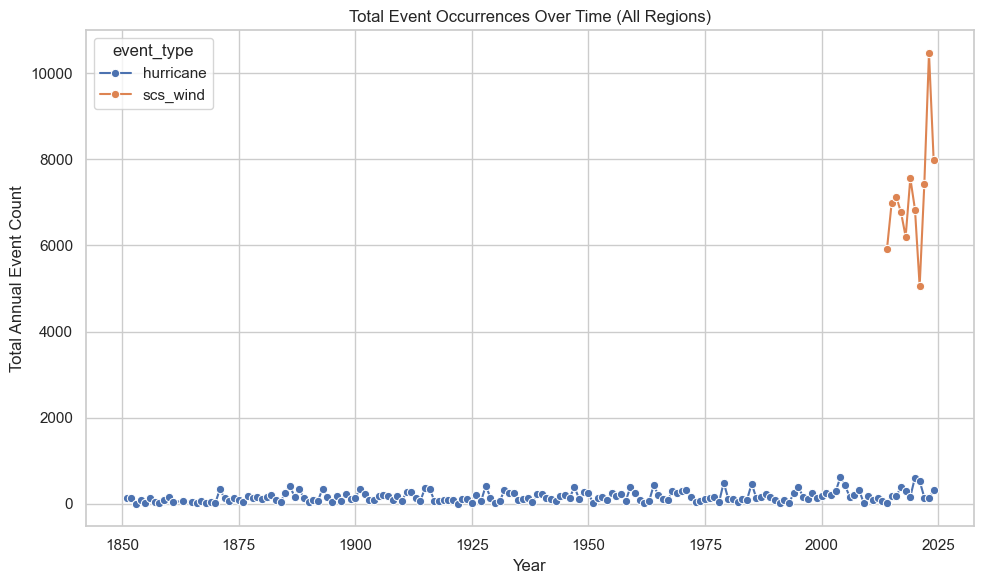

[2025-04-10 15:51:14] [INFO] FittingLogger - Calculated event counts per county, type, and year. Result shape: (38529, 5)



--- Event Counts per County, Type, Year (Sample) ---


,county_geoid,region,event_type,year,event_count
0,12001,Southeast,hurricane,1867,1
1,12001,Southeast,hurricane,1871,3
2,12001,Southeast,hurricane,1874,1
3,12001,Southeast,hurricane,1877,1
4,12001,Southeast,hurricane,1878,1


[2025-04-10 15:51:14] [INFO] FittingLogger - Calculated average annual events per county:
      region event_type  event_count
0      South  hurricane     1.094577
1      South   scs_wind     5.970530
2  Southeast  hurricane     1.126971
3  Southeast   scs_wind     7.021559
4       West  hurricane     1.054015
5       West   scs_wind     5.079468



--- Average Annual Events per County (per Region/Type) ---


,region,event_type,event_count
0,South,hurricane,1.094577
1,South,scs_wind,5.970530
2,Southeast,hurricane,1.126971
3,Southeast,scs_wind,7.021559
4,West,hurricane,1.054015
5,West,scs_wind,5.079468


[2025-04-10 15:51:14] [INFO] FittingLogger - Saved county-year frequency data to ../output/analysis\freq_county_year.csv
[2025-04-10 15:51:14] [INFO] FittingLogger - --- Frequency Analysis Complete ---


In [4]:
# --- Frequency Analysis ---
logger.info("--- Starting Frequency Analysis ---")

if df_county_events.empty or df_counties.empty:
    logger.error("Cannot perform frequency analysis because county_events or county definitions are missing.")
else:
    # Aggregate: Count events per region, event_type, year
    df_freq_region_year = df_county_events.groupby(['region', 'event_type', 'year']).size().reset_index(name='event_count')
    logger.info("Calculated total event counts per region, type, and year.")
    print("\n--- Total Events per Region, Type, Year ---")
    display(df_freq_region_year.head())

    # Plot total events per year by type (across all regions for overview)
    print("\n--- Plotting Total Events Over Time ---")
    plt.figure()
    sns.lineplot(data=df_freq_region_year, x='year', y='event_count', hue='event_type', estimator='sum', errorbar=None, marker='o')
    plt.title('Total Event Occurrences Over Time (All Regions)')
    plt.ylabel('Total Annual Event Count')
    plt.xlabel('Year')
    plt.tight_layout()
    plt.savefig(os.path.join(ANALYSIS_OUTPUT_DIR, 'total_events_over_time.png'))
    plt.show()

    # Aggregate: Count events per county, event_type, year
    # This is the core data for fitting frequency distributions per county
    df_freq_county_year = df_county_events.groupby(['county_geoid', 'region', 'event_type', 'year']).size().reset_index(name='event_count')
    logger.info(f"Calculated event counts per county, type, and year. Result shape: {df_freq_county_year.shape}")
    print("\n--- Event Counts per County, Type, Year (Sample) ---")
    display(df_freq_county_year.head())

    # Calculate average events per county per year (for context)
    avg_events = df_freq_county_year.groupby(['region', 'event_type'])['event_count'].mean().reset_index()
    logger.info(f"Calculated average annual events per county:\n{avg_events.to_string()}")
    print("\n--- Average Annual Events per County (per Region/Type) ---")
    display(avg_events)

    # Save frequency aggregation
    freq_county_path = os.path.join(ANALYSIS_OUTPUT_DIR, 'freq_county_year.csv')
    df_freq_county_year.to_csv(freq_county_path, index=False)
    logger.info(f"Saved county-year frequency data to {freq_county_path}")

logger.info("--- Frequency Analysis Complete ---")

## 2. Fit Frequency Distributions

Now, we fit statistical distributions (Poisson, Negative Binomial) to the historical event counts. We'll perform this fitting, for example, for hurricanes in the Southeast region. The output will include fitted parameters and goodness-of-fit statistics.

In [5]:
# --- Frequency Distribution Fitting ---
logger.info("--- Starting Frequency Distribution Fitting ---")

# Helper function for Chi-squared goodness-of-fit test for discrete distributions
def chi_squared_gof(observed_counts, expected_counts):
    """ Robust Chi-squared GoF test with normalization for sum mismatch. """
    total_observed = np.sum(observed_counts)
    total_expected = np.sum(expected_counts)

    # --- Normalization Fix ---
    # Adjust expected counts slightly to match total observed, handling potential zero sum
    # Use a tolerance check for floating point comparisons
    if total_expected > 1e-9 and not np.isclose(total_observed, total_expected):
        logger.debug(f"Normalizing expected counts sum ({total_expected}) to match observed sum ({total_observed}) for Chi2 test.")
        expected_counts = (expected_counts / total_expected) * total_observed
        # Verify after normalization
        total_expected = np.sum(expected_counts)
        if not np.isclose(total_observed, total_expected):
             logger.warning(f"Normalization failed to exactly match sums: Obs={total_observed}, Exp={total_expected}. Chi2 test might still fail.")
    # --- End Fix ---

    # Ensure no zero/tiny expected counts where observed is non-zero
    valid_indices = expected_counts > 1e-9 # Use a small threshold instead of > 0 for float
    if np.sum(observed_counts[~valid_indices]) > 0:
         logger.warning("Observed counts exist where expected counts are zero/tiny. GoF test may be unreliable.")
         return np.nan, np.nan

    observed = observed_counts[valid_indices]
    expected = expected_counts[valid_indices]

    # Check degrees of freedom requirement
    if len(observed) <= 1:
        logger.warning("Not enough bins (<=1) after filtering for Chi-squared test.")
        return np.nan, np.nan

    # Pool low expected frequencies warning
    min_expected_freq = 5.0
    if np.any(expected < min_expected_freq):
        logger.warning(f"Some expected frequencies < {min_expected_freq}. Chi-squared test validity might be reduced. Consider bin pooling (not implemented here).")

    try:
        # ddof = degrees of freedom correction (k-1, where k is # estimated parameters)
        # This should ideally be passed based on the distribution fitted (1 for Poisson, 2 for Nbinom)
        # For simplicity, keeping ddof=0 here, acknowledging it might make test conservative.
        chisq_stat, p_value = stats.chisquare(f_obs=observed, f_exp=expected, ddof=0)
        # Check if test returned NaN despite normalization
        if np.isnan(chisq_stat):
             logger.error("Chi2 calculation resulted in NaN despite normalization. Check input arrays for other issues (e.g., non-finite values).")
             return np.nan, np.nan
        return chisq_stat, p_value
    except ValueError as e:
        # Catching potential errors from chisquare if sums still mismatch critically
        logger.error(f"ValueError during chisquare calculation (sums likely still mismatch): {e}")
        return np.nan, np.nan


# Function to fit distributions and evaluate
def fit_frequency_distribution(data, dist_names=['poisson', 'nbinom']):
    """
    Fits specified discrete distributions to the count data.
    Returns fitted parameters and GoF results.
    """
    results = {}
    if len(data) == 0:
        logger.warning("No data provided for frequency fitting.")
        for dist_name in dist_names:
             results[dist_name] = {'params': None, 'gof_chisq': np.nan, 'gof_p_value': np.nan}
        return results

    observed_freq = Counter(data)
    max_observed_count = max(observed_freq.keys()) if observed_freq else 0
    possible_counts = np.arange(max_observed_count + 1) # Counts from 0 up to max observed

    # Get observed frequencies for the range 0 to max_observed_count
    observed_counts_array = np.array([observed_freq.get(i, 0) for i in possible_counts])
    total_observations = len(data) # This is the correct total sum for observed

    for dist_name in dist_names:
        logger.debug(f"Fitting {dist_name} distribution...")
        params = None
        expected_counts_array = np.zeros_like(possible_counts, dtype=float)
        gof_chisq, gof_p = np.nan, np.nan

        try:
            if dist_name == 'poisson':
                lambda_est = np.mean(data)
                if np.isnan(lambda_est): raise ValueError("Mean is NaN, cannot fit Poisson.")
                params = (lambda_est,)
                pmf = stats.poisson.pmf(possible_counts, mu=lambda_est)
                expected_counts_array = pmf * total_observations # Calculate expected based on total obs

            elif dist_name == 'nbinom':
                mean_val = np.mean(data)
                var_val = np.var(data)
                if np.isnan(mean_val) or np.isnan(var_val): raise ValueError("Mean or Variance is NaN, cannot fit Nbinom.")

                if var_val <= mean_val * (1 + 1e-9): # Add small tolerance for variance check
                    logger.warning(f"Variance ({var_val:.4f}) <= Mean ({mean_val:.4f}). Negative Binomial might not be theoretically ideal, but attempting fit.")

                if var_val < 1e-9 : # Check if variance is effectively zero
                    logger.warning("Variance is near zero. Nbinom fit might be degenerate.")
                    if np.isclose(mean_val, 0):
                        params = (0, 1) # Represents 0 counts certainly
                        logger.debug("Mean count is near 0, fitting degenerate nbinom(0,1).")
                    else:
                         logger.warning("Skipping Nbinom fit due to near-zero variance with non-zero mean.")
                         params = None
                elif mean_val < 1e-9: # Check if mean is effectively zero
                     params = (0, 1) # Represents 0 counts certainly
                     logger.debug("Mean count is near 0, fitting degenerate nbinom(0,1).")
                else:
                    # Method of moments estimates
                    p_est = mean_val / var_val
                    p_est = max(min(p_est, 1.0 - 1e-9), 1e-9) # Clamp p slightly away from 0 and 1
                    n_est = mean_val * p_est / (1 - p_est)
                    n_est = max(n_est, 1e-9) # Clamp n slightly above 0
                    params = (n_est, p_est)

                if params is not None:
                    pmf = stats.nbinom.pmf(possible_counts, n=params[0], p=params[1])
                    expected_counts_array = pmf * total_observations # Calculate expected based on total obs

            if params is not None:
                # Perform Chi-squared GoF test using the helper function with normalization
                gof_chisq, gof_p = chi_squared_gof(observed_counts_array, expected_counts_array)
                logger.debug(f"{dist_name} fitted. Params: {params}, ChiSq: {gof_chisq:.4f}, P-value: {gof_p:.4f}")

            results[dist_name] = {
                'params': params,
                'gof_chisq': gof_chisq,
                'gof_p_value': gof_p
            }

        except Exception as e:
            logger.exception(f"Failed to fit {dist_name} distribution: {e}")
            results[dist_name] = {'params': None, 'gof_chisq': np.nan, 'gof_p_value': np.nan}

    return results

# --- Example Fitting: Hurricanes in Southeast ---
if 'df_county_events' not in locals() or df_county_events.empty or 'df_counties' not in locals() or df_counties.empty:
     logger.error("Skipping frequency fitting as county_events data or county definitions are missing or failed to load.")
else:
    target_region = 'Southeast'
    target_event = 'hurricane'

    logger.info(f"\n--- Fitting Frequency Distributions for {target_event.capitalize()} in {target_region} ---")
    # Check if region mapping produced results before proceeding
    if 'region' not in df_county_events.columns or df_county_events['region'].isnull().all():
         logger.error(f"Region column missing or all null in df_county_events. Cannot perform regional analysis for {target_region}.")
    elif df_county_events[df_county_events['region'] == target_region].empty:
         logger.warning(f"No events mapped to the target region '{target_region}'. Skipping fitting.")
    else:
        logger.warning("NOTE: Regional analysis might be incomplete due to a large number of events not matching county definitions.") # Keep warning about merge issue

        # Get the relevant data: counts per county per year for this event/region
        if 'df_freq_county_year' not in locals() or df_freq_county_year.empty:
             logger.error("DataFrame 'df_freq_county_year' not defined or empty. Frequency analysis likely failed or was skipped. Cannot proceed with fitting.")
        else:
            freq_data_subset = df_freq_county_year[
                (df_freq_county_year['region'] == target_region) &
                (df_freq_county_year['event_type'] == target_event)
            ]

            if freq_data_subset.empty:
                logger.warning(f"No frequency data found for {target_event} in {target_region} after filtering. Skipping fitting.")
            else:
                # Prepare the full dataset including zero counts for county-years with no events
                min_year_float = df_freq_county_year['year'].dropna().min() # Add dropna
                max_year_float = df_freq_county_year['year'].dropna().max() # Add dropna

                if pd.isna(min_year_float) or pd.isna(max_year_float):
                    logger.error("Cannot determine year range because min/max year is NaN. Check 'year' column extraction.")
                else:
                    min_year = int(min_year_float)
                    max_year = int(max_year_float)
                    logger.info(f"Year range for analysis: {min_year} to {max_year}")
                    years = range(min_year, max_year + 1)

                    all_counties_region = df_counties[df_counties['region'] == target_region]['county_geoid'].unique()
                    if len(all_counties_region) == 0:
                        logger.warning(f"No counties found defined for region {target_region}. Cannot perform regional fitting.")
                    else:
                        # Create a full index of county-year pairs for the target region
                        full_index = pd.MultiIndex.from_product([all_counties_region, years], names=['county_geoid', 'year'])
                        df_full_county_year = pd.DataFrame(index=full_index).reset_index()

                        # Merge the observed counts onto the full index
                        df_merged = pd.merge(
                            df_full_county_year,
                            freq_data_subset[['county_geoid', 'year', 'event_count']],
                            on=['county_geoid', 'year'],
                            how='left'
                        ).fillna({'event_count': 0}) # Fill non-observed county-years with 0 events

                        # Data for fitting is the 'event_count' column
                        data_to_fit = df_merged['event_count'].astype(int).values

                        if len(data_to_fit) == 0:
                             logger.warning("No data available to fit after merging and filtering.")
                        else:
                            logger.info(f"Fitting distributions to {len(data_to_fit)} county-year observations for {target_event} in {target_region}.")
                            # Fit distributions
                            fitting_results = fit_frequency_distribution(data_to_fit)

                            # Log and print results
                            logger.info(f"Frequency Fitting Results ({target_event}/{target_region}):")
                            print(f"\n--- Frequency Fitting Results ({target_event}/{target_region}) ---")
                            for dist_name, result in fitting_results.items():
                                # Format params for printing
                                if result['params'] is not None:
                                    param_str = ", ".join([f"{p:.4f}" for p in result['params']])
                                else:
                                    param_str = "None"
                                log_msg = f"Distribution: {dist_name}, Params: ({param_str}), ChiSq GoF: {result.get('gof_chisq', np.nan):.4f}, P-value: {result.get('gof_p_value', np.nan):.4f}"
                                logger.info(log_msg)
                                print(log_msg)

                        # You would repeat this fitting process for other event types/regions as needed

logger.info("--- Frequency Distribution Fitting Complete ---")

[2025-04-10 15:51:14] [INFO] FittingLogger - --- Starting Frequency Distribution Fitting ---
[2025-04-10 15:51:14] [INFO] FittingLogger - 
--- Fitting Frequency Distributions for Hurricane in Southeast ---
[2025-04-10 15:51:14] [WARNING] FittingLogger - NOTE: Regional analysis might be incomplete due to a large number of events not matching county definitions.
[2025-04-10 15:51:14] [INFO] FittingLogger - Year range for analysis: 1851 to 2024
[2025-04-10 15:51:14] [INFO] FittingLogger - Fitting distributions to 107184 county-year observations for hurricane in Southeast.
[2025-04-10 15:51:14] [WARNING] FittingLogger - Some expected frequencies < 5.0. Chi-squared test validity might be reduced. Consider bin pooling (not implemented here).
[2025-04-10 15:51:14] [ERROR] FittingLogger - ValueError during chisquare calculation (sums likely still mismatch): For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1.


--- Frequency Fitting Results (hurricane/Southeast) ---
Distribution: poisson, Params: (0.1700), ChiSq GoF: nan, P-value: nan
Distribution: nbinom, Params: (2.1969, 0.9282), ChiSq GoF: 3.6099, P-value: 0.4614


## 3. Analyze Historical Event Severity

Here, we examine the characteristics of severity metrics from the original cleaned datasets (HURDAT max wind, Wildfire acres burned, etc.).

[2025-04-10 15:51:14] [INFO] FittingLogger - --- Starting Severity Analysis ---
[2025-04-10 15:51:14] [INFO] FittingLogger - 
--- Analyzing Hurricane Severity (Max Wind Knots) ---
[2025-04-10 15:51:14] [INFO] FittingLogger - Using 55173 non-null max_wind_knots values for analysis.
[2025-04-10 15:51:14] [INFO] FittingLogger - Descriptive Stats:
count    55173.000000
mean        52.675312
std         24.593975
min         10.000000
25%         35.000000
50%         45.000000
75%         70.000000
max        165.000000



--- Hurricane Severity (max_wind_knots) ---
Descriptive Stats:


count    55173.000000
mean        52.675312
std         24.593975
min         10.000000
25%         35.000000
50%         45.000000
75%         70.000000
max        165.000000
Name: max_wind_knots, dtype: float64

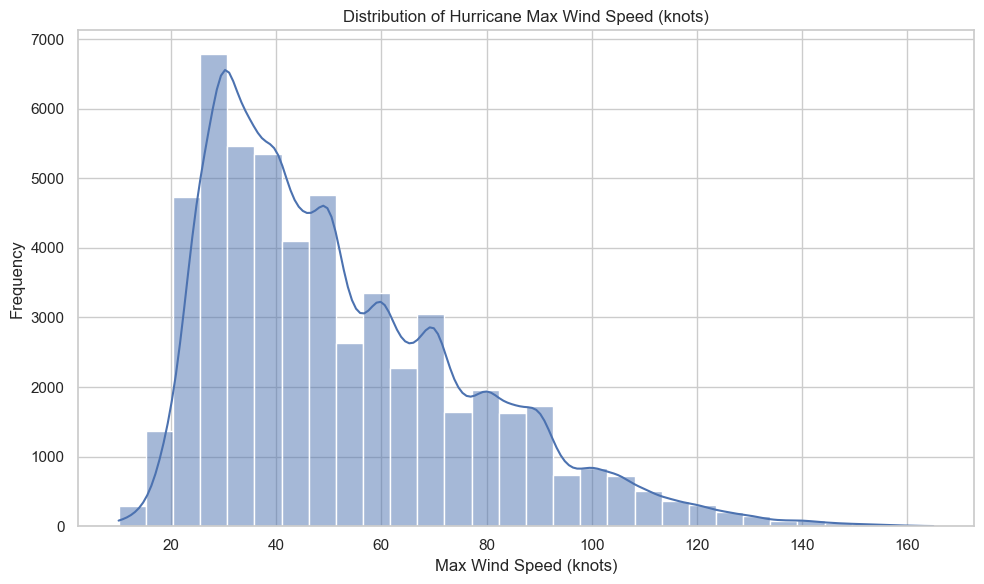

[2025-04-10 15:51:16] [INFO] FittingLogger - 
--- Analyzing Wildfire Severity (Acres Burned) ---
[2025-04-10 15:51:16] [INFO] FittingLogger - Using 2794 non-null incident_acres_burned values (2770 positive values).
[2025-04-10 15:51:16] [INFO] FittingLogger - Descriptive Stats (all non-null):
count    2.794000e+03
mean     4.254046e+03
std      3.509720e+04
min      0.000000e+00
25%      3.000000e+01
50%      8.250000e+01
75%      3.410000e+02
max      1.032648e+06



--- Wildfire Severity (incident_acres_burned) ---
Descriptive Stats (all non-null):


count    2.794000e+03
mean     4.254046e+03
std      3.509720e+04
min      0.000000e+00
25%      3.000000e+01
50%      8.250000e+01
75%      3.410000e+02
max      1.032648e+06
Name: incident_acres_burned, dtype: float64

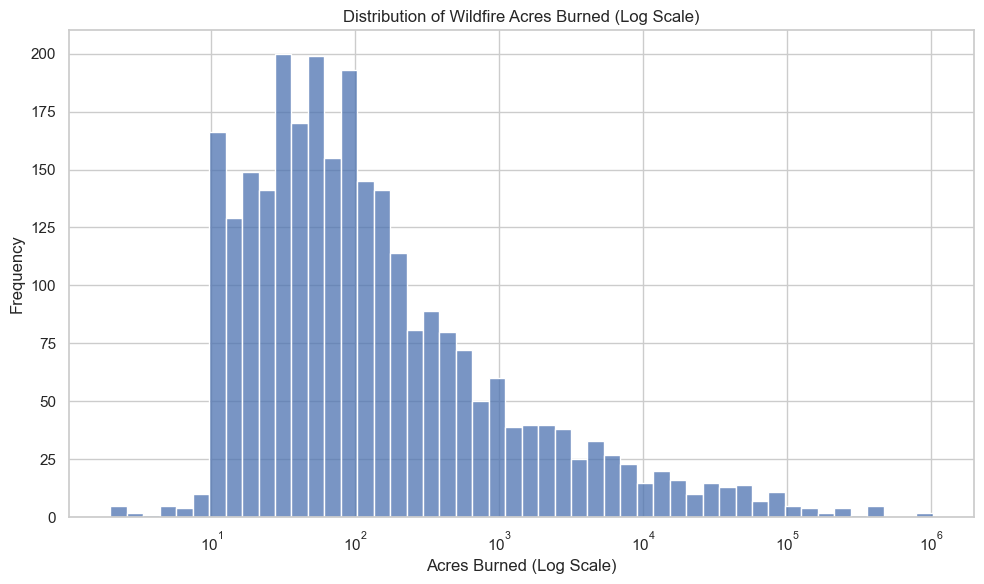

[2025-04-10 15:51:17] [INFO] FittingLogger - 
--- Analyzing SCS Wind Severity (Magnitude, if available) ---
[2025-04-10 15:51:17] [INFO] FittingLogger - Using 238858 non-null numeric MAGNITUDE values for analysis.
[2025-04-10 15:51:17] [INFO] FittingLogger - Descriptive Stats:
count    238858.000000
mean         53.123885
std           7.632774
min           1.000000
25%          50.000000
50%          52.000000
75%          56.000000
max         173.000000



--- SCS Wind Severity (MAGNITUDE) ---
Descriptive Stats:


count    238858.000000
mean         53.123885
std           7.632774
min           1.000000
25%          50.000000
50%          52.000000
75%          56.000000
max         173.000000
Name: MAGNITUDE, dtype: float64

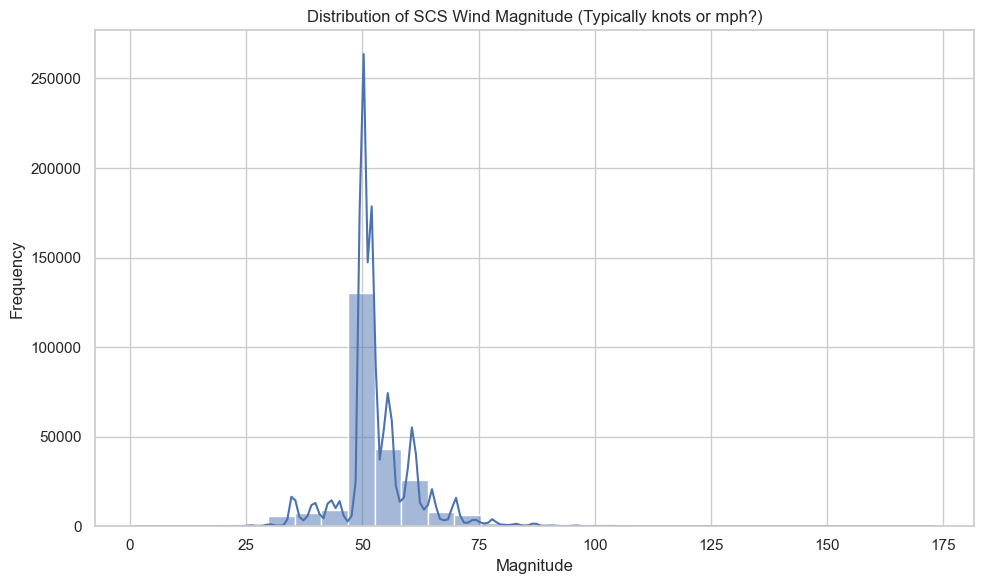

[2025-04-10 15:51:19] [INFO] FittingLogger - --- Severity Analysis Complete ---


In [6]:
# --- Severity Analysis ---
logger.info("--- Starting Severity Analysis ---")

severity_summaries = {}

# --- Hurricane Severity (Max Wind Speed) ---
if not df_hurdat.empty and 'max_wind_knots' in df_hurdat.columns:
    logger.info("\n--- Analyzing Hurricane Severity (Max Wind Knots) ---")
    severity_col = 'max_wind_knots'
    hurr_severity = df_hurdat[severity_col].dropna()
    logger.info(f"Using {len(hurr_severity)} non-null {severity_col} values for analysis.")
    print(f"\n--- Hurricane Severity ({severity_col}) ---")
    desc = hurr_severity.describe()
    logger.info(f"Descriptive Stats:\n{desc.to_string()}")
    print("Descriptive Stats:")
    display(desc)
    severity_summaries['hurricane_wind'] = desc

    # Plot histogram
    plt.figure()
    sns.histplot(hurr_severity, kde=True, bins=30)
    plt.title('Distribution of Hurricane Max Wind Speed (knots)')
    plt.xlabel('Max Wind Speed (knots)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(os.path.join(ANALYSIS_OUTPUT_DIR, 'hist_hurricane_wind.png'))
    plt.show()
else:
    logger.warning("Skipping Hurricane severity analysis: DataFrame empty or 'max_wind_knots' column missing.")

# --- Wildfire Severity (Acres Burned) ---
if not df_wildfires.empty and 'incident_acres_burned' in df_wildfires.columns:
    logger.info("\n--- Analyzing Wildfire Severity (Acres Burned) ---")
    severity_col = 'incident_acres_burned'
    # Filter out non-positive values if distributions require it (e.g., Lognormal)
    wildfire_severity = df_wildfires[severity_col].dropna()
    wildfire_severity_positive = wildfire_severity[wildfire_severity > 0]
    logger.info(f"Using {len(wildfire_severity)} non-null {severity_col} values ({len(wildfire_severity_positive)} positive values).")
    print(f"\n--- Wildfire Severity ({severity_col}) ---")
    desc = wildfire_severity.describe()
    logger.info(f"Descriptive Stats (all non-null):\n{desc.to_string()}")
    print("Descriptive Stats (all non-null):")
    display(desc)
    severity_summaries['wildfire_acres'] = desc

    # Plot histogram (use positive values for log scale, or all for linear)
    plt.figure()
    # Use log scale due to expected skewness
    sns.histplot(wildfire_severity_positive, kde=False, bins=50, log_scale=True)
    plt.title('Distribution of Wildfire Acres Burned (Log Scale)')
    plt.xlabel('Acres Burned (Log Scale)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(os.path.join(ANALYSIS_OUTPUT_DIR, 'hist_wildfire_acres_log.png'))
    plt.show()
else:
    logger.warning("Skipping Wildfire severity analysis: DataFrame empty or 'incident_acres_burned' column missing.")

# --- SCS Wind Severity (Magnitude - IF AVAILABLE) ---
if not df_stormevents.empty and 'MAGNITUDE' in df_stormevents.columns:
    logger.info("\n--- Analyzing SCS Wind Severity (Magnitude, if available) ---")
    # Filter for wind events first
    wind_types = ['Thunderstorm Wind', 'High Wind', 'Strong Wind'] # Focus on non-marine for magnitude relevance
    df_scs_wind = df_stormevents[df_stormevents['EVENT_TYPE'].isin(wind_types)].copy()
    severity_col = 'MAGNITUDE'
    scs_severity = df_scs_wind[severity_col].dropna()

    if not scs_severity.empty:
        # Convert magnitude to numeric, coercing errors
        scs_severity = pd.to_numeric(scs_severity, errors='coerce').dropna()
        logger.info(f"Using {len(scs_severity)} non-null numeric {severity_col} values for analysis.")
        print(f"\n--- SCS Wind Severity ({severity_col}) ---")
        desc = scs_severity.describe()
        logger.info(f"Descriptive Stats:\n{desc.to_string()}")
        print("Descriptive Stats:")
        display(desc)
        severity_summaries['scs_wind_magnitude'] = desc

        # Plot histogram
        plt.figure()
        sns.histplot(scs_severity, kde=True, bins=30)
        plt.title('Distribution of SCS Wind Magnitude (Typically knots or mph?)')
        plt.xlabel('Magnitude')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.savefig(os.path.join(ANALYSIS_OUTPUT_DIR, 'hist_scs_wind_magnitude.png'))
        plt.show()
    else:
        logger.warning("No non-null numeric MAGNITUDE data found for SCS Wind events.")
else:
    logger.warning("Skipping SCS Wind severity analysis: DataFrame empty or 'MAGNITUDE' column missing.")


logger.info("--- Severity Analysis Complete ---")

## 4. Fit Severity Distributions

We fit continuous distributions (e.g., Gamma, Lognormal, Weibull) to the severity data. We'll use the Kolmogorov-Smirnov test for goodness-of-fit. Note that some distributions (like Lognormal) require strictly positive data.

In [7]:
# --- Severity Distribution Fitting ---
logger.info("--- Starting Severity Distribution Fitting ---")

# Function to fit continuous distributions and evaluate GoF using K-S test
def fit_severity_distribution(data, dist_names=['gamma', 'lognorm', 'weibull_min']):
    """
    Fits specified continuous distributions to the severity data.
    Returns fitted parameters and K-S GoF test results.
    Filters data to be positive for distributions that require it.
    """
    results = {}
    original_n = len(data)

    for dist_name in dist_names:
        logger.debug(f"Attempting to fit {dist_name} distribution...")
        params = None
        ks_stat, ks_p = np.nan, np.nan
        data_to_fit = data # Default to using all data

        # Special handling for distributions requiring positive data
        if dist_name in ['gamma', 'lognorm']:
            data_to_fit = data[data > 0]
            if len(data_to_fit) == 0:
                logger.warning(f"No positive data available for {dist_name} fitting. Skipping.")
                results[dist_name] = {'params': None, 'ks_stat': np.nan, 'ks_p_value': np.nan, 'n_fitted': 0}
                continue
            elif len(data_to_fit) < original_n:
                 logger.debug(f"Using {len(data_to_fit)} positive values (out of {original_n}) for {dist_name} fit.")


        if len(data_to_fit) < 2: # Need at least 2 points to fit most distributions
             logger.warning(f"Not enough data points ({len(data_to_fit)}) to fit {dist_name}. Skipping.")
             results[dist_name] = {'params': None, 'ks_stat': np.nan, 'ks_p_value': np.nan, 'n_fitted': len(data_to_fit)}
             continue

        try:
            # Get the distribution object from scipy.stats
            dist = getattr(stats, dist_name)

            # Fit distribution to data
            # For gamma and weibull, fix location (loc=0) if theoretically appropriate (e.g., severity cannot be negative)
            # For lognorm, standard fit estimates shape, loc, scale. loc corresponds to threshold.
            if dist_name in ['gamma', 'weibull_min']:
                 params = dist.fit(data_to_fit, floc=0) # Fix location to 0
            else:
                 params = dist.fit(data_to_fit)

            # Perform Kolmogorov-Smirnov GoF test
            ks_stat, ks_p = stats.kstest(data_to_fit, dist_name, args=params)
            logger.debug(f"{dist_name} fitted. Params: {params}, KS Stat: {ks_stat:.4f}, P-value: {ks_p:.4f}")

            results[dist_name] = {
                'params': params,
                'ks_stat': ks_stat,
                'ks_p_value': ks_p,
                'n_fitted': len(data_to_fit)
            }

        except Exception as e:
            logger.exception(f"Failed to fit {dist_name} distribution: {e}")
            results[dist_name] = {'params': None, 'ks_stat': np.nan, 'ks_p_value': np.nan, 'n_fitted': len(data_to_fit)}

    return results

# --- Example Fitting: Hurricane Max Wind ---
if 'hurricane_wind' in severity_summaries: # Check if analysis was performed
    logger.info("\n--- Fitting Severity Distributions for Hurricane Max Wind ---")
    # Use the non-null data from the analysis step
    data_to_fit = df_hurdat['max_wind_knots'].dropna()
    if not data_to_fit.empty:
        fitting_results = fit_severity_distribution(data_to_fit)
        print("\n--- Severity Fitting Results (Hurricane Max Wind) ---")
        logger.info("Severity Fitting Results (Hurricane Max Wind):")
        for dist_name, result in fitting_results.items():
             log_msg = f"Dist: {dist_name}, N_fit: {result['n_fitted']}, Params: {result['params']}, KS Stat: {result['ks_stat']:.4f}, P-value: {result['ks_p_value']:.4f}"
             logger.info(log_msg)
             print(log_msg)
    else:
         logger.warning("No data available to fit hurricane wind severity.")


# --- Example Fitting: Wildfire Acres Burned ---
if 'wildfire_acres' in severity_summaries:
    logger.info("\n--- Fitting Severity Distributions for Wildfire Acres Burned ---")
    # Use positive non-null acres for fitting, especially for lognorm/gamma
    data_to_fit = df_wildfires['incident_acres_burned'].dropna()
    # data_to_fit = data_to_fit[data_to_fit > 0] # This filtering now happens inside fit_severity_distribution

    if not data_to_fit.empty:
        fitting_results = fit_severity_distribution(data_to_fit)
        print("\n--- Severity Fitting Results (Wildfire Acres Burned) ---")
        logger.info("Severity Fitting Results (Wildfire Acres Burned):")
        for dist_name, result in fitting_results.items():
             log_msg = f"Dist: {dist_name}, N_fit: {result['n_fitted']}, Params: {result['params']}, KS Stat: {result['ks_stat']:.4f}, P-value: {result['ks_p_value']:.4f}"
             logger.info(log_msg)
             print(log_msg)
    else:
         logger.warning("No data available to fit wildfire acres burned severity.")

# --- Example Fitting: SCS Wind Magnitude ---
if 'scs_wind_magnitude' in severity_summaries:
     logger.info("\n--- Fitting Severity Distributions for SCS Wind Magnitude ---")
     # Re-extract the valid numeric magnitude data
     wind_types = ['Thunderstorm Wind', 'High Wind', 'Strong Wind']
     df_scs_wind = df_stormevents[df_stormevents['EVENT_TYPE'].isin(wind_types)].copy()
     scs_severity = df_scs_wind['MAGNITUDE'].dropna()
     data_to_fit = pd.to_numeric(scs_severity, errors='coerce').dropna()

     if not data_to_fit.empty:
         fitting_results = fit_severity_distribution(data_to_fit)
         print("\n--- Severity Fitting Results (SCS Wind Magnitude) ---")
         logger.info("Severity Fitting Results (SCS Wind Magnitude):")
         for dist_name, result in fitting_results.items():
              log_msg = f"Dist: {dist_name}, N_fit: {result['n_fitted']}, Params: {result['params']}, KS Stat: {result['ks_stat']:.4f}, P-value: {result['ks_p_value']:.4f}"
              logger.info(log_msg)
              print(log_msg)
     else:
          logger.warning("No data available to fit SCS wind magnitude severity.")


logger.info("--- Severity Distribution Fitting Complete ---")

[2025-04-10 15:51:19] [INFO] FittingLogger - --- Starting Severity Distribution Fitting ---
[2025-04-10 15:51:19] [INFO] FittingLogger - 
--- Fitting Severity Distributions for Hurricane Max Wind ---
[2025-04-10 15:51:20] [INFO] FittingLogger - Severity Fitting Results (Hurricane Max Wind):
[2025-04-10 15:51:20] [INFO] FittingLogger - Dist: gamma, N_fit: 55173, Params: (4.99374907769357, 0, np.float64(10.548249697827565)), KS Stat: 0.1028, P-value: 0.0000
[2025-04-10 15:51:20] [INFO] FittingLogger - Dist: lognorm, N_fit: 55173, Params: (np.float64(0.5086771336656913), 4.557737833895598, np.float64(42.388398769076815)), KS Stat: 0.0808, P-value: 0.0000
[2025-04-10 15:51:20] [INFO] FittingLogger - Dist: weibull_min, N_fit: 55173, Params: (np.float64(2.2881894230974535), 0, np.float64(59.70618203913292)), KS Stat: 0.1087, P-value: 0.0000
[2025-04-10 15:51:20] [INFO] FittingLogger - 
--- Fitting Severity Distributions for Wildfire Acres Burned ---
[2025-04-10 15:51:20] [INFO] FittingLogger


--- Severity Fitting Results (Hurricane Max Wind) ---
Dist: gamma, N_fit: 55173, Params: (4.99374907769357, 0, np.float64(10.548249697827565)), KS Stat: 0.1028, P-value: 0.0000
Dist: lognorm, N_fit: 55173, Params: (np.float64(0.5086771336656913), 4.557737833895598, np.float64(42.388398769076815)), KS Stat: 0.0808, P-value: 0.0000
Dist: weibull_min, N_fit: 55173, Params: (np.float64(2.2881894230974535), 0, np.float64(59.70618203913292)), KS Stat: 0.1087, P-value: 0.0000

--- Severity Fitting Results (Wildfire Acres Burned) ---
Dist: gamma, N_fit: 2770, Params: (0.21126921971566112, 0, np.float64(20310.123627540685)), KS Stat: 0.2914, P-value: 0.0000
Dist: lognorm, N_fit: 2770, Params: (np.float64(2.1343228362778492), 1.9239598918546543, np.float64(128.66937148244077)), KS Stat: 0.1037, P-value: 0.0000
Dist: weibull_min, N_fit: 2794, Params: (np.float64(0.38550874638072585), 0, np.float64(397.0808186453822)), KS Stat: 0.1966, P-value: 0.0000


[2025-04-10 15:51:24] [INFO] FittingLogger - Severity Fitting Results (SCS Wind Magnitude):
[2025-04-10 15:51:24] [INFO] FittingLogger - Dist: gamma, N_fit: 238858, Params: (49.901124817193356, 0, np.float64(1.0645829230422865)), KS Stat: 0.2513, P-value: 0.0000
[2025-04-10 15:51:24] [INFO] FittingLogger - Dist: lognorm, N_fit: 238858, Params: (np.float64(0.09855370483291531), -22.612238138286777, np.float64(75.36604636785674)), KS Stat: 0.2508, P-value: 0.0000
[2025-04-10 15:51:24] [INFO] FittingLogger - Dist: weibull_min, N_fit: 238858, Params: (np.float64(5.8706428491180525), 0, np.float64(56.42556041972669)), KS Stat: 0.2865, P-value: 0.0000
[2025-04-10 15:51:24] [INFO] FittingLogger - --- Severity Distribution Fitting Complete ---



--- Severity Fitting Results (SCS Wind Magnitude) ---
Dist: gamma, N_fit: 238858, Params: (49.901124817193356, 0, np.float64(1.0645829230422865)), KS Stat: 0.2513, P-value: 0.0000
Dist: lognorm, N_fit: 238858, Params: (np.float64(0.09855370483291531), -22.612238138286777, np.float64(75.36604636785674)), KS Stat: 0.2508, P-value: 0.0000
Dist: weibull_min, N_fit: 238858, Params: (np.float64(5.8706428491180525), 0, np.float64(56.42556041972669)), KS Stat: 0.2865, P-value: 0.0000


## 5. Summary and Next Steps

The analysis above provides:
- Aggregated historical event frequencies per county/region and year.
- Fitted parameters for frequency distributions (e.g., Poisson, Negative Binomial) for selected event types/regions.
- Descriptive statistics and visualizations for key severity metrics.
- Fitted parameters for severity distributions (e.g., Gamma, Lognormal, Weibull) for selected event types.
- Goodness-of-fit metrics (Chi-squared for frequency, K-S for severity) to help assess model suitability.

**Next Steps:**

1.  **Review Fitted Distributions:** Examine the parameters and GoF p-values. Choose the best-fitting distribution for frequency and severity for each event type/region relevant to the project. A low p-value (e.g., < 0.05) suggests the distribution is a poor fit.
2.  **Define Scenarios:** Quantify the "Low," "Base," and "High" impact scenarios by specifying adjustments to the *parameters* of the chosen distributions (e.g., increase the Poisson lambda rate, or shift the scale parameter of the Gamma severity distribution).
3.  **Implement Monte Carlo Simulation:** Use the chosen distributions and scenario adjustments to simulate event occurrences and severities over the next 10 years (N10Y).